# Importing Library

In [21]:
from tensorflow.keras import datasets # type: ignore
import matplotlib.pyplot as plt# type: ignore
from sklearn.model_selection import train_test_split# type: ignore
from keras import Sequential
from keras.layers import Dense,Flatten,Dropout, GlobalAveragePooling2D, UpSampling2D,InputLayer, BatchNormalization # type: ignore
import tensorflow as tf
import cv2 # type: ignore
import numpy as np

In [22]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

# Load the dataset

In [23]:
(x_train,y_train),(x_test,y_test) = datasets.cifar10.load_data()

# Data Visualization

In [24]:
x_train.shape

(50000, 32, 32, 3)

In [25]:
y_train.shape

(50000, 1)

In [26]:
x_test.shape

(10000, 32, 32, 3)

In [27]:
y_test.shape

(10000, 1)

In [28]:
y_train = y_train.reshape(-1,)
y_test = y_test.reshape(-1,)

## Function for unloading meta file from cifar 10 dataset website

In [29]:
## Obtained from https://www.cs.toronto.edu/~kriz/cifar.html
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Unload meta file

In [30]:
meta_data = unpickle('batches.meta')

In [31]:
classes = meta_data[b'label_names']
classes = [item.decode()for item in classes]

# List of cifar 10 dataset class

In [32]:
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

# Showing sample images

In [33]:
def show_image(x,y,index):
  plt.figure(figsize=(15,6))
  plt.imshow(x[index])
  plt.xlabel(classes[y[index]])

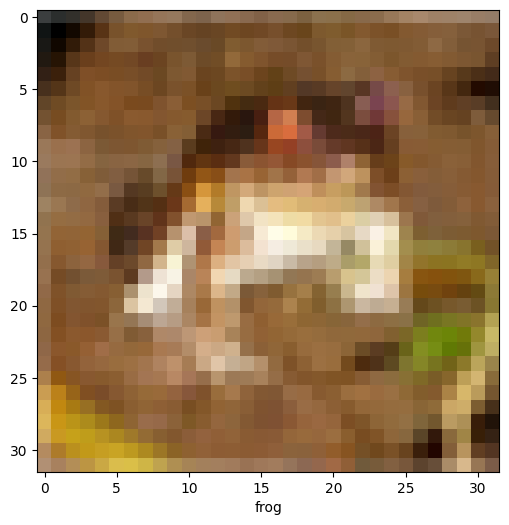

In [34]:
show_image(x_train,y_train,0)

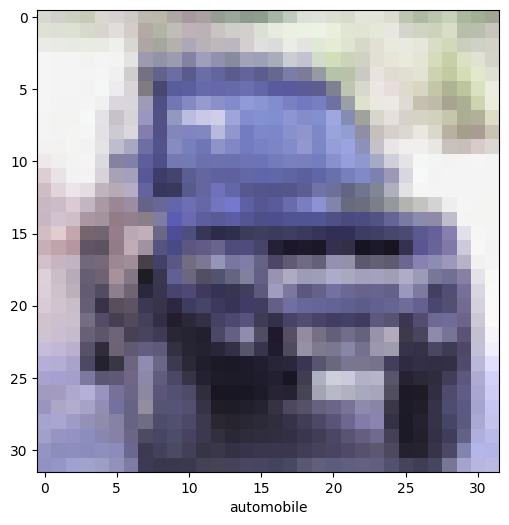

In [35]:
show_image(x_test,y_test,9)

# Splitting data

Originally, there were 50000 training data 10000 testing data
the ratio is 83.33% for training data and 16.67% for testing data

The training data will be further split into training data and validation data, where the data split would be:

Training data = 40000 (66.67%)

Validation data = 10000 (16.67%)

Testing data = 10000 (16.67%)

In [36]:
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.2,random_state=42)

In [37]:
print("Training data count: ",len(x_train))
print("Validation data count: ",len(x_val))
print("Testing data count: ",len(x_test))

Training data count:  40000
Validation data count:  10000
Testing data count:  10000


# Data Augmentation

In [38]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
   
    rotation_range=20,
    
    width_shift_range=0.14,
    
    height_shift_range=0.14,
    
    horizontal_flip=True,
    
    zoom_range=0.11,
    
    brightness_range=[0.9,1.1],
    
    shear_range=0.12,

    channel_shift_range=0.1,
    

)

Augment the training data

In [39]:
x_train = data_generator.flow(x_train,y_train,batch_size=len(x_train))

In [40]:
x_train,y_train = next(x_train)

In [41]:
x_train.shape

(40000, 32, 32, 3)

# Normalizing data to 0-1

In [42]:
x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255
x_val = x_val.astype("float32")/255

In [43]:
class_length = len(classes)

In [44]:
x_train.shape

(40000, 32, 32, 3)

# Building the model

In [45]:
resnet_model = tf.keras.applications.ResNet50(
      include_top=False,
      weights="imagenet",
      input_shape=(64, 64,3),
      pooling = "avg"
    )

model = Sequential([
    InputLayer(input_shape=(32,32,3)),
    UpSampling2D((2,2)),
    resnet_model,
    Flatten(),
    BatchNormalization(),
    Dense(128,activation='relu'),
    Dropout(0.25),
    BatchNormalization(),
    Dense(64,activation='relu'),
    Dropout(0.25),
    BatchNormalization(),
    Dense(class_length,activation='softmax')

])

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2D  (None, 64, 64, 3)        0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0

In [47]:
from tensorflow.keras import mixed_precision # type: ignore
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU, compute capability 8.6


In [48]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [49]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [50]:
history = model.fit(x_train,y_train,epochs=10,validation_data=(x_val,y_val), callbacks=[early_stopping])

Epoch 1/10
1250/1250 [==============================] - 211s 157ms/step - loss: 2.0401 - accuracy: 0.3281 - val_loss: 1.0860 - val_accuracy: 0.6508
Epoch 2/10
1250/1250 [==============================] - 197s 157ms/step - loss: 1.1888 - accuracy: 0.6188 - val_loss: 0.7052 - val_accuracy: 0.7827
Epoch 3/10
1250/1250 [==============================] - 201s 161ms/step - loss: 0.8639 - accuracy: 0.7322 - val_loss: 0.5607 - val_accuracy: 0.8244
Epoch 4/10
1250/1250 [==============================] - 198s 158ms/step - loss: 0.6547 - accuracy: 0.8054 - val_loss: 0.5119 - val_accuracy: 0.8410
Epoch 5/10
1250/1250 [==============================] - 197s 158ms/step - loss: 0.5025 - accuracy: 0.8561 - val_loss: 0.4939 - val_accuracy: 0.8503
Epoch 6/10
1250/1250 [==============================] - 200s 160ms/step - loss: 0.3831 - accuracy: 0.8940 - val_loss: 0.4729 - val_accuracy: 0.8582
Epoch 7/10
1250/1250 [==============================] - 200s 160ms/step - loss: 0.2931 - accuracy: 0.9214 - val_

In [29]:
model.save("ResNet50.h5")

In [30]:
from tensorflow.keras.models import load_model # type: ignore

model = load_model("ResNet50.h5")  

In [51]:
loss,accuracy = model.evaluate(x_test,y_test)

print("Accuracy: " + str(accuracy*100) + "%")

313/313 [==============================] - 7s 24ms/step - loss: 0.5412 - accuracy: 0.8593
Accuracy: 85.93000173568726%


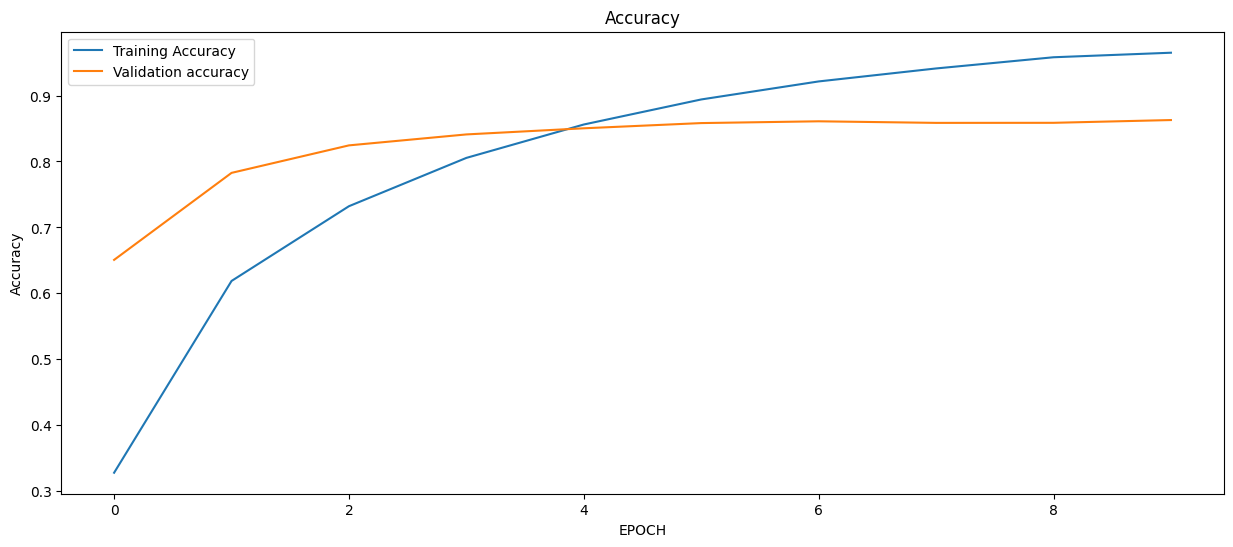

In [52]:
plt.figure(figsize=(15,6))
plt.plot(history.history['accuracy'],label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'],label = 'Validation accuracy')
plt.title('Accuracy')
plt.xlabel('EPOCH')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

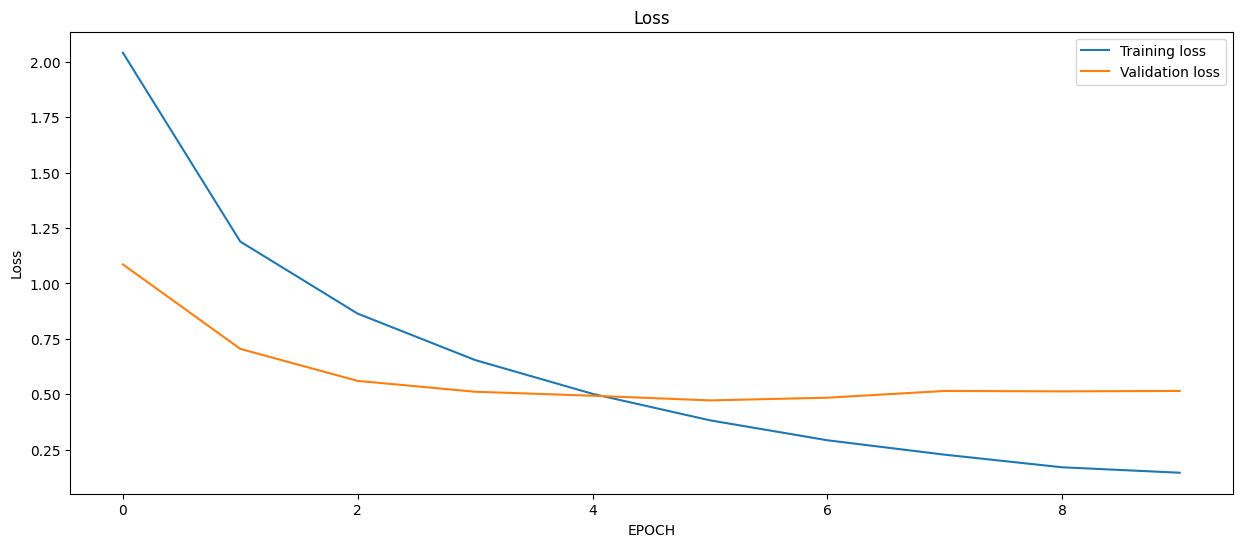

In [53]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'],label = 'Training loss')
plt.plot(history.history['val_loss'],label = 'Validation loss')
plt.title('Loss')
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.legend()
plt.show()